# Generating relative value trade ideas using PCA

The goal of this exercise is to implement a framework for identifying and analyzing relative value trades using PCA and Python. 

## Setting it up

Let's first import the dependencies we will need. 

In [1]:
%matplotlib inline

import quandl

import numpy as np
from numpy import array
import pandas as pd
from operator import sub
import pickle
import math
import itertools as iter
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, rc
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA, KernelPCA

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

print ("Loaded!")

Loaded!


We will be performing our exercise on the German yield curve from Quandl. Free data is available from January 2010 to December 2014.

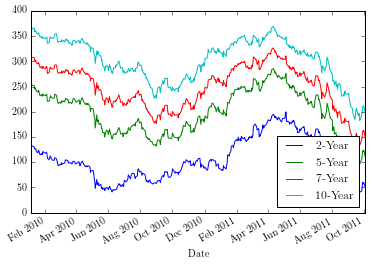

In [5]:
data = quandl.get("YC/DEU", authtoken="hHmwzKyDyqaHhJLF1eFe")

#Let's focus on 2y, 5y, 7y, 10y, 20y and 30y
assets = ['2-Year', '5-Year', '7-Year', '10-Year']
data = data[assets]

#convert to bps
data *= 100

start = dt.datetime(2010, 1, 4)
end = dt.datetime(2011, 10, 3)

data = data[start:end]

data.plot()


## change dates

## Writing the static PCA function

We'll try to write a function staticPCA. It takes in our raw data, number of components we are interested in (default 4) and resample frequency on the raw data (default 1). It also takes in corrW (default 20), which is used to determine how many periods to use in the rolling correlation of reconstructed factors.

The output of the function will be a dictionary of resultant eigenvalues, eigenvectors, the covariance matrix, and historical reconstructed factors.

In [2]:
def staticPCA(data, n=3, freq=1, corrW = 12):
    '''
    This function returns a dictionary with the following key value combinations:
    key    | Value
    raw    | DF with raw data (as resampled)
    covM   | Covariance matrix of raw data
    evals  | n eigenvalues
    evecs  | n eigenvectors
    facTS  | time series of reconstructed factors using raw data. 
    reRaw  | Rebuilt raw data from n EVs, and accompanying residuals
    resid  | Residuals (Actual - Reconstructed)
    facCR  | Rolling cross correlations between factors
    '''
    results = {}
    
    ## resample data based on freq and calc demeaned data
    raw = data.iloc[::freq, :]
    results["rawDat"] = raw
    meanVals = raw.mean()
    demeaned = raw - meanVals
    
    ## Covariance Matrix
    covM = raw.cov()
    results["covM"] = covM

    ## PCA
    evals, evecs = np.linalg.eig(covM)
    epairs = [(np.abs(evals[i]), evecs[:,i]) for i in range(len(evals))]
    epairs.sort(key=lambda x: x[0], reverse=True)
    evals = sorted([i*100/sum(evals) for i in evals])[::-1][:n]
    results["evals"] = evals

    evTable = pd.DataFrame(index=covM.index)
    for i in range(n):
        evTable.insert(i, "PC"+str(i+1), epairs[i][1])
    results["evecs"] = evTable

    ## Reconstruct
    facTS = demeaned.dot(evTable)
    invEV = pd.DataFrame(np.linalg.pinv(evTable.values), evTable.columns, evTable.index)
    reRaw = facTS.dot(invEV) + meanVals
    resid = raw - reRaw

    results["facTS"] = facTS
    results["reRaw"] = reRaw
    results["resid"] = resid

    ## Rolling correlations of factors
    facCR = pd.DataFrame()
    combos =[facTS[list(pair)] for pair in list(iter.combinations(facTS.columns, 2))]
    for df in combos:
        cols = df.columns.values
        facCR["".join(cols)] = facTS[cols[0]].rolling(window=corrW).corr(other=facTS[cols[1]])

    results["facCR"] = facCR
    return results


## Playing around with the function results

Let's load our German Yield curve data into this function and see what we get.

[91.339485460872737, 8.5440018346113753, 0.10867269358368825]
              PC1       PC2       PC3
2-Year   0.438234  0.820231  0.353456
5-Year   0.536120  0.054305 -0.630920
7-Year   0.525500 -0.265548 -0.254924
10-Year  0.494344 -0.503742  0.641890
[0.43823403792890192, 0.53611981901319905, 0.52550027766446827, 0.49434393476237887]


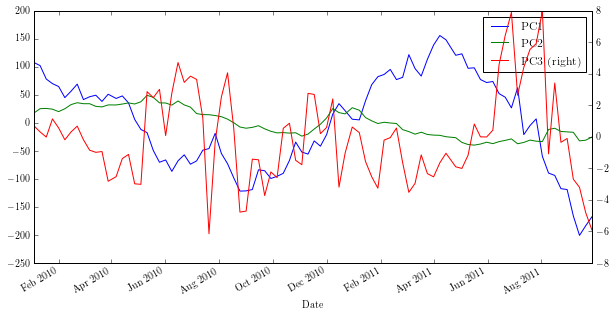

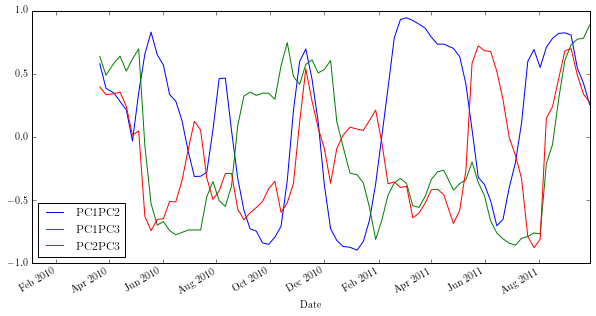

In [6]:
pca = staticPCA(data, freq=5, n=3)

print (pca["evals"])
print (pca["evecs"])

print (pca["evecs"]["PC1"].tolist())

pca["facTS"]["PC2"] = -pca["facTS"]["PC2"]
pca["facTS"]["PC3"] = pca["facTS"]["PC3"]


pca["facTS"].plot(figsize=(10, 5), secondary_y='PC3')

pca["facCR"].plot(figsize=(10,5))


It's actually not good that the factors exhibit such high correlations, as it makes it more difficult to construct trades that are representative of a single factor.

At the end of the exercise, we will dive quite a bit deeper into the results. For now, let's implement a rolling PCA using our staticPCA function.

# Rolling PCA

Here we try to implement a rolling PCA in order to study the stability of eigenvectors and eigenvalues over time.


In [67]:
def rollingPCA(data, lb=30, n=3, freq=1, corrW=12, skip=1):
    """
    For now, this function returns a time series of eigenvalues and eigenvectors of a rolling PCA. 
    """
    lb = 30
    n=3
    freq=1
    corrW=12
    skip=1

    rollResult = {}
    
    assets = data.columns.values
    pcCols = ["PC"+str(i+1) for i in range(n)]
    
    # Create dataframe for results. 
    accumEvals = pd.DataFrame(columns = range(1, n+1), index=data.index.values[lb:])
    accumEvecs = dict.fromkeys(pcCols, pd.DataFrame(columns=assets, index=data.index.values[lb:]))

    for i in range(0, len(data.index)-lb, skip):
        
        temp = data[i:lb+i]
        currDate = data.index.values[lb+i]
        res = staticPCA(temp, n=n, freq=freq, corrW=corrW)

        ## Save eigenvalues
        eigenvalues = res["evals"]
        for j in range(len(eigenvalues)):
            accumEvals.set_value(currDate,j+1,eigenvalues[j])
        accumEvals = accumEvals.dropna()

        ## Save eigenvectors
        eigenvectors = res["evecs"]
        for pc in pcCols:
            factor = eigenvectors[pc].tolist()
            for j in range(len(assets)):
                accumEvecs[pc].set_value(currDate, assets[j], factor[j])

    for pcdf in accumEvecs:
        accumEvecs[pcdf] = accumEvecs[pcdf].dropna()
    
    rollResult["evectors"] = accumEvecs
    rollResult["evalues"] = accumEvals
    
    return rollResult
            

df = rollingPCA(data)["evectors"]["PC1"]
print ("Done")

Done


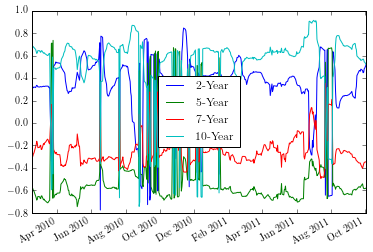

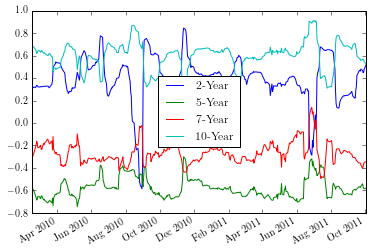

In [68]:

def cleanPCs(data):
    newdf = pd.DataFrame(index=df.index.values, columns=df.columns.values)
    flag = "flipped"

    for i in range(1, len(df)):
        if i ==1:
            prevfactor = df.iloc[i-1]
        else:
            prevfactor = newdf.iloc[i-1]
        factor = df.iloc[i]
        negfactor = [-i for i in factor.tolist()]

        #orig = sum([np.abs(x) for x in (factor-prevfactor).tolist()])
        #new = sum([np.abs(x) for x in (-factor-prevfactor).tolist()])


        #alternate
        oldfacsign  = np.sign(prevfactor.tolist())
        currfacsign = np.sign(factor.tolist())
        orig = sum([i==j for i, j in zip(oldfacsign, currfacsign)])
        negfacsign = np.sign(negfactor)
        new = sum([i==j for i, j in zip(oldfacsign, negfacsign)])



        if orig < new:
            for s in range(len(df.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], -1*df.iloc[i, s])
                flag = "flipped"
        else:
            for s in range(len(df.columns.values)):
                newdf.set_value(newdf.index.values[i], newdf.columns.values[s], df.iloc[i, s])
                flag = "same"
        """      
        print (i, df.index.values[i])
        print ("\t Prev Fac: %s"%prevfactor.tolist())
        print ("\t Factor: %s"%factor.tolist())
        print (flag)
        """
        
    return newdf
            
df.plot()
cleanPCs(df).plot()

